# Using *distinctiveness*, *saliency* and *topic-word relevance* scores

This uses a topic model generated from a **tiny subset** of the Reuters data included in the [lda package](http://pythonhosted.org/lda/).

**Please note that this is a really tiny corpus in order to make this example more managable and faster to process. The results are not representative for the whole corpus though!** 

In [1]:
# load complete model
import numpy as np
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle

data = load_ldamodel_from_pickle('data/tiny_model_reuters_5_topics.pickle')

dtm = data['dtm']
model = data['model']
vocab = np.array(data['vocab'])     # this must be a NumPy array too
doc_labels = data ['doc_labels']

n_docs, n_topics = model.doc_topic_.shape
vocab_size = len(vocab)

print('model with %d topics learnt from %d documents with vocabulary size of %d unique words'
      % (n_topics, n_docs, vocab_size))

ModuleNotFoundError: No module named 'tmtoolkit'

## Preparation

For the further calculations, we need the marignal topic distribution $P(T)$ which shows how prominent each topic is for the whole corpus. In order to calculate this distribution we also need the *document lengths* at first, i.e. the number of tokens in each document.

In [2]:
from tmtoolkit.topicmod.model_stats import get_doc_lengths, get_marginal_topic_distrib

doc_lengths = get_doc_lengths(dtm)
print('document lengths (num. of tokens per doc.): %s' % doc_lengths)

p_t = get_marginal_topic_distrib(model.doc_topic_, doc_lengths)
print('marginal topic distribution P(T): %s' % p_t)

document lengths (num. of tokens per doc.): [257 207  92 237 243 258 202 257 377 167]
marginal topic distribution P(T): [0.19971492 0.20981363 0.155547   0.21806089 0.21686357]


## Per-word scores: *distinctiveness* and *saliency* ([Chuang et al. 2012](https://dl.acm.org/citation.cfm?id=2254572))

Used to reflect some kind of "importance" of word for the whole corpus. Very often occurring but very general words will be ranked lower, whereas more specific but less often occuring words will be ranked higher.

Calculation of the *word distinctiveness* score for the whole vocabulary in the corpus.

In [3]:
from tmtoolkit.topicmod.model_stats import get_word_distinctiveness

word_distinct_score = get_word_distinctiveness(model.topic_word_, p_t)
assert len(word_distinct_score) == len(vocab)

list(zip(word_distinct_score, vocab))[:20]

[(1.567557839995289, 'church'),
 (1.8487588975321945, 'pope'),
 (1.5350692077322396, 'years'),
 (1.5790444909859604, 'people'),
 (1.5056846411313132, 'mother'),
 (1.4888057029699904, 'last'),
 (1.5790444909859604, 'told'),
 (1.5212332503446993, 'first'),
 (1.567557839995289, 'world'),
 (1.1082922680986158, 'year'),
 (1.4866306697490315, 'president'),
 (1.5001167907794926, 'teresa'),
 (1.3946818394723828, 'charles'),
 (0.8830486070624138, 'catholic'),
 (1.0983062482241566, 'during'),
 (1.3375488988775075, 'life'),
 (1.4866306697490315, 'u.s'),
 (1.44785948361881, 'city'),
 (1.5251250317648284, 'public'),
 (1.567557839995289, 'time')]

Shortcut for getting only the $n$ most or least distinctive words:

In [4]:
from tmtoolkit.topicmod.model_stats import get_most_distinct_words, get_least_distinct_words

most_distinct = get_most_distinct_words(vocab, model.topic_word_, model.doc_topic_, doc_lengths, 10)
least_distinct = get_least_distinct_words(vocab, model.topic_word_, model.doc_topic_, doc_lengths, 10)

print('10 most distinct words: %s' % most_distinct)
print('10 least distinct words: %s' % least_distinct)

10 most distinct words: ['pope' 'poles' 'political' 'john' 'poland' 'while' 'polish' 'krakow'
 'economic' 'trip']
10 least distinct words: ['since' 'day' 'wednesday' 'fever' 'probably' 'month' 'september' 'open'
 'catholic' 'white']


Calculation of the *word saliency* score for the whole vocabulary in the corpus.

In [5]:
from tmtoolkit.topicmod.model_stats import get_word_saliency

word_saliency_score = get_word_saliency(model.topic_word_, model.doc_topic_, doc_lengths)

assert len(word_saliency_score) == len(vocab)

list(zip(word_saliency_score, vocab))[:20]

[(0.004694679823037349, 'church'),
 (0.01800598709115149, 'pope'),
 (0.00852331518185614, 'years'),
 (0.006741452711996873, 'people'),
 (0.014136377465043155, 'mother'),
 (0.0025654185896164185, 'last'),
 (0.006741452711996873, 'told'),
 (0.005210272055795865, 'first'),
 (0.004694679823037349, 'world'),
 (0.0037976718628003575, 'year'),
 (0.00129464906367136, 'president'),
 (0.010251675858018661, 'teresa'),
 (0.0006221025878627883, 'charles'),
 (0.001895565957668264, 'catholic'),
 (0.002348683602127693, 'during'),
 (0.0005975082618732783, 'life'),
 (0.00129464906367136, 'u.s'),
 (0.0024967088514994324, 'city'),
 (0.005872501456164301, 'public'),
 (0.004694679823037349, 'time')]

Shortcut for getting only the $n$ most or least salient words:

In [6]:
from tmtoolkit.topicmod.model_stats import get_most_salient_words, get_least_salient_words

most_salient = get_most_salient_words(vocab, model.topic_word_, model.doc_topic_, doc_lengths, 10)
least_salient = get_least_distinct_words(vocab, model.topic_word_, model.doc_topic_, doc_lengths, 10)

print('10 most salient words: %s' % most_salient)
print('10 least salient words: %s' % least_salient)

10 most salient words: ['duke' 'pope' 'british' 'mother' 'official' 'teresa' 'order' 'years'
 'king' 'west']
10 least salient words: ['since' 'day' 'wednesday' 'fever' 'probably' 'month' 'september' 'open'
 'catholic' 'white']


## Topic-word relevance score ([Sievert and Shirley 2014](http://www.aclweb.org/anthology/W14-3110))

Used to determine the "importance" for words of the corpus for a given topic (**not** the whole corpus). Very frequent but unspecific words will be ranked lower than more specific but less frequent words. Weight parameter $\lambda$ defines the influence of a word's *lift* within a topic (the ratio of a term's probability within a topic to its marginal probability across the whole corpus). Setting $\lambda=1$ means no influence of the lift quantity and results in the same ranking as given by the topic-word distribution. $\lambda=0$ only uses lift for the ranking.

Please note that the $\lambda$ parameter of the relevance score functions in *tmtoolkit* can be set with `lambda_=...`. Mind the underscore at the end. This is because `lambda` is a keyword of the Python programming language.

Calculate the relevance score from the model using a specific value of $\lambda$. The result is a $N \times M$ matrix with $N$ being the number of topics and $M$ being the size of the vocabulary.

In [7]:
from tmtoolkit.topicmod.model_stats import get_topic_word_relevance

rel_mat = get_topic_word_relevance(model.topic_word_, model.doc_topic_, doc_lengths, lambda_=0.6)
assert rel_mat.shape == (n_topics, vocab_size)

rel_mat

array([[-1.88133385, -8.90555324, -8.68076929, ..., -7.67303231,
        -7.67010531, -3.05703018],
       [-8.48160531, -8.95331681, -1.55764439, ..., -7.72079589,
        -7.71786888, -7.71991427],
       [-8.18926862, -0.91988103, -8.43619617, ..., -7.42845919,
        -2.81041167, -7.42757758],
       [-8.51941098, -8.99112248, -8.76633854, ..., -3.14348104,
        -7.75567455, -7.75771994],
       [-8.51353587, -8.98524737, -8.76046342, ..., -7.75272644,
        -7.74979944, -7.75184483]])

Shortcut for getting only the $n$ most or least relevant words in a given topic:

In [8]:
from tmtoolkit.topicmod.model_stats import get_most_relevant_words_for_topic, get_least_relevant_words_for_topic

topic = 3    # topic to choose from 0..n_topics-1
most_relevant = get_most_relevant_words_for_topic(vocab, rel_mat, topic, 10)
least_relevant = get_least_relevant_words_for_topic(vocab, rel_mat, topic, 10)

print('10 most relevant words in topic %d: %s' % (topic, most_relevant))
print('10 least relevant words in topic %d: %s' % (topic, least_relevant))

10 most relevant words in topic 3: ['mother' 'teresa' 'order' 'bethlehem' 'tree' 'heart' 'christmas'
 'hospital' 'charity' 'year']
10 least relevant words in topic 3: ['duke' 'pope' 'british' 'official' 'king' 'years' 'west' 'war'
 'churchill' 'government']


### Generate wordclouds for relevance scores

For each topic, create a word cloud according to the relevance scores of this topic's terms:

In [9]:
from tmtoolkit.topicmod.visualize import generate_wordcloud_from_weights

# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

top_n = 20    # number of top relevance words to show

wordclouds = []
for t_idx in range(n_topics):
    sorted_weights = list(sorted(zip(vocab, rel_mat[topic]), key=lambda x: x[1], reverse=True))
    top_weights = dict(sorted_weights[:top_n])
    wordclouds.append(generate_wordcloud_from_weights(top_weights, width=img_w, height=img_h))


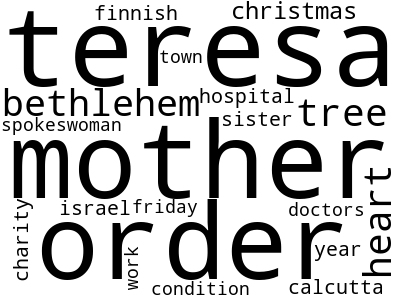

In [10]:
# example output: topic #4 (index 3)

wordclouds[3]

In [11]:
# save as PNG images:
#for i, wc_img in enumerate(wordclouds):
#    wc_img.save('topic_%d.png' % (i+1))